In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

from pymc.gp.util import plot_gp_dist
from sklearn.preprocessing import StandardScaler


plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
seed: int = sum(map(ord, "bikes"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

In [3]:
data_path = "https://raw.githubusercontent.com/christophM/interpretable-ml-book/master/data/bike.csv"

raw_data_df = pd.read_csv(
    data_path,
    dtype={
        "season": "category",
        "mnth": "category",
        "holiday": "category",
        "weekday": "category",
        "workingday": "category",
        "weathersit": "category",
        "cnt": "int",
    },
)

data_df = raw_data_df.copy()

data_df["date"] = pd.to_datetime("2011-01-01") + data_df["days_since_2011"].apply(
    lambda z: pd.Timedelta(z, unit="D")
)

data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   season           731 non-null    category      
 1   yr               731 non-null    int64         
 2   mnth             731 non-null    category      
 3   holiday          731 non-null    category      
 4   weekday          731 non-null    category      
 5   workingday       731 non-null    category      
 6   weathersit       731 non-null    category      
 7   temp             731 non-null    float64       
 8   hum              731 non-null    float64       
 9   windspeed        731 non-null    float64       
 10  cnt              731 non-null    int64         
 11  days_since_2011  731 non-null    int64         
 12  date             731 non-null    datetime64[ns]
dtypes: category(6), datetime64[ns](1), float64(3), int64(3)
memory usage: 45.6 KB


In [4]:
target = "cnt"
target_scaled = f"{target}_scaled"

endog_scaler = StandardScaler()
exog_scaler = StandardScaler()


data_df[target_scaled] = endog_scaler.fit_transform(X=data_df[[target]])
data_df[["temp_scaled", "hum_scaled", "windspeed_scaled"]] = exog_scaler.fit_transform(
    X=data_df[["temp", "hum", "windspeed"]]
)

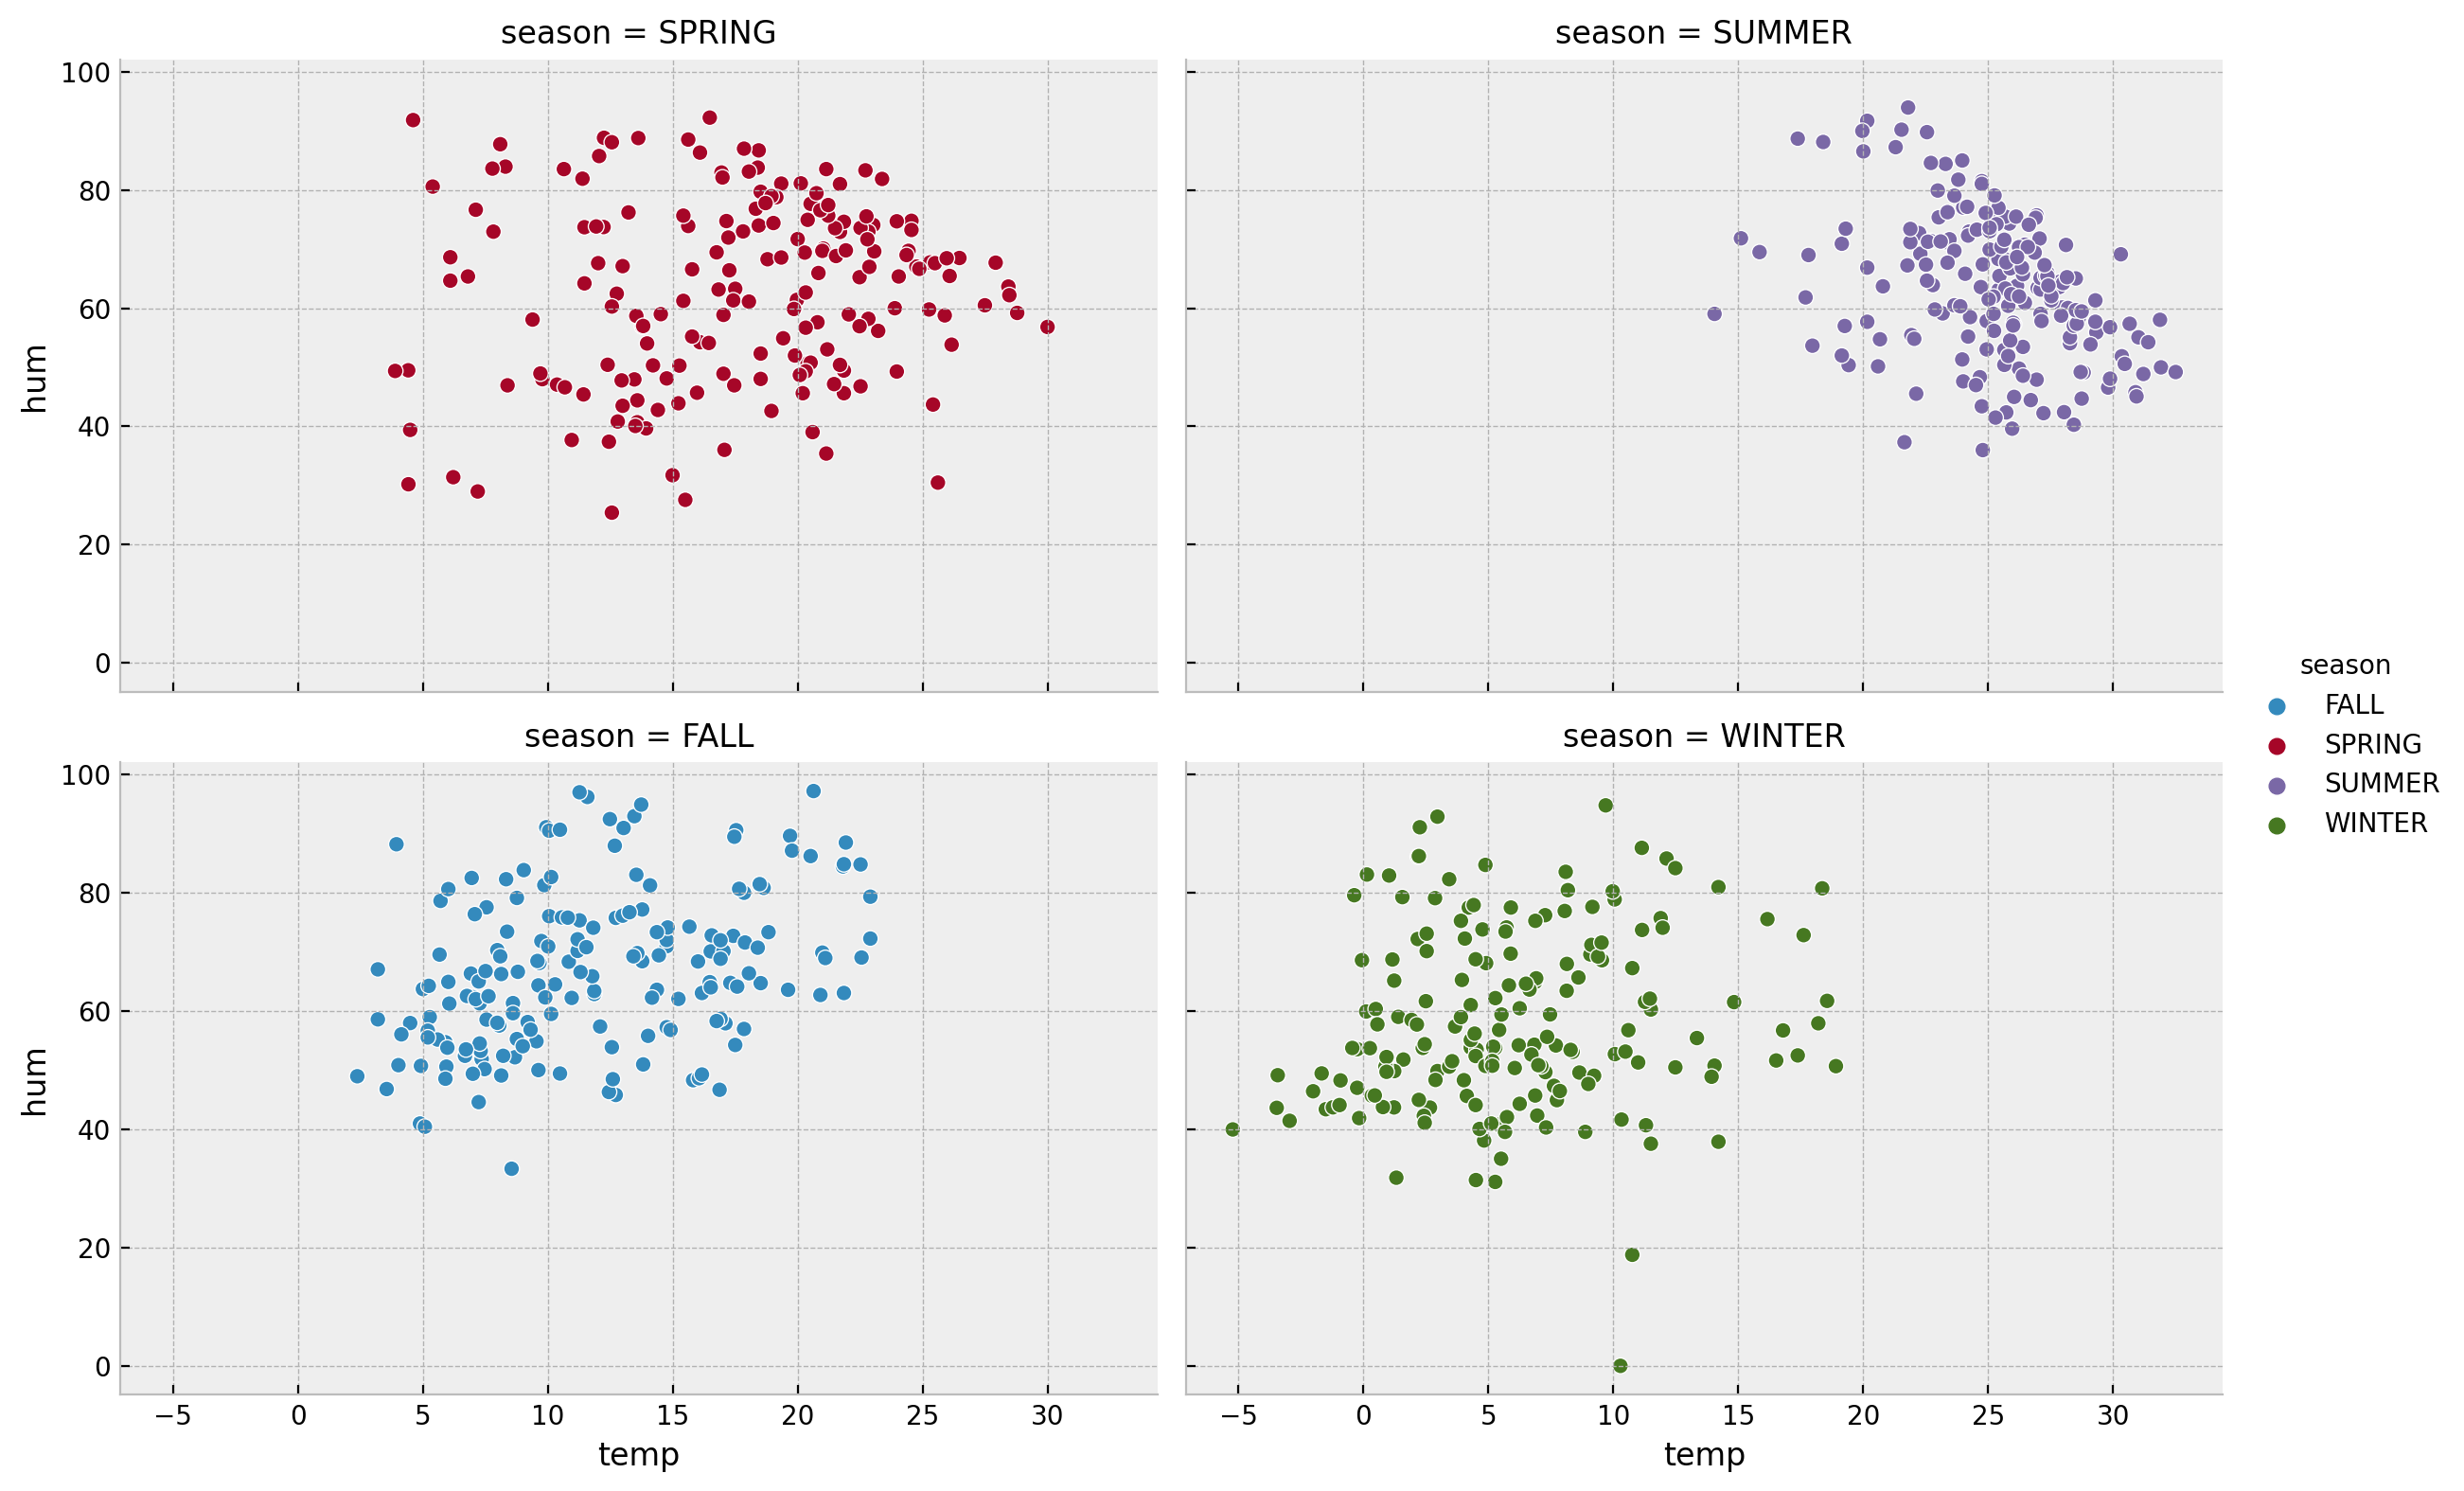

In [5]:
g = sns.relplot(
    data=data_df,
    x="temp",
    y="hum",
    hue="season",
    col="season",
    col_wrap=2,
    col_order=["SPRING", "SUMMER", "FALL", "WINTER"],
    height=4,
    aspect=1.5,
)


In [6]:
n = data_df.shape[0]
# target
cnt = data_df[target].to_numpy()
cnt_scaled = data_df[target_scaled].to_numpy()
# date feature
date = data_df["date"].to_numpy()
# model regressors
temp_scaled = data_df["temp_scaled"].to_numpy()
hum_scaled = data_df["hum_scaled"].to_numpy()
windspeed_scaled = data_df["windspeed_scaled"].to_numpy()
holiday_idx, holiday = data_df["holiday"].factorize(sort=True)
workingday_idx, workingday = data_df["workingday"].factorize(sort=True)
weathersit_idx, weathersit = data_df["weathersit"].factorize(sort=True)
t = data_df["days_since_2011"].to_numpy() / data_df["days_since_2011"].max()

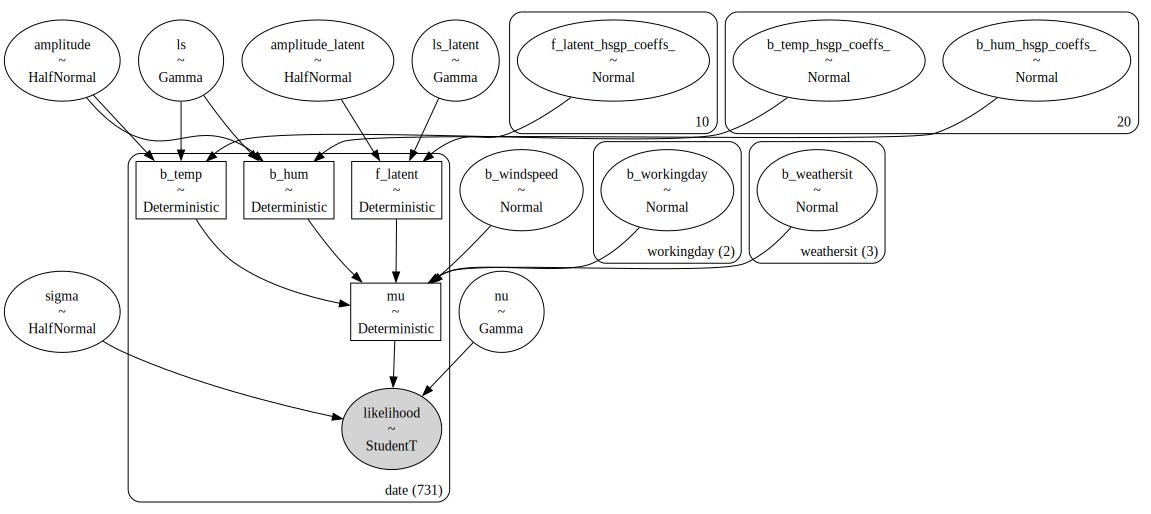

In [7]:
coords = {
    "date": date,
    "workingday": workingday,
    "weathersit": weathersit,
}


with pm.Model(coords=coords) as model:
    # --- priors ---
    # intercept = pm.Normal(name="intercept", mu=0, sigma=1)

    ls_latent = pm.Gamma(name="ls_latent", alpha=0.01, beta=1)
    amplitude_latent = pm.HalfNormal(name="amplitude_latent", sigma=1)
    cov_latent = amplitude_latent**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ls_latent)
    gp_latent = pm.gp.HSGP(m=[10], c=1.3, cov_func=cov_latent)
    f_latent = gp_latent.prior(name="f_latent", X=t[:, None], dims="date")

    ls = pm.Gamma(name="ls", alpha=0.3, beta=1)
    amplitude = pm.HalfNormal(name="amplitude", sigma=0.5)

    # ls_temp = pm.Gamma(name="ls_temp", alpha=1, beta=2)
    # amplitude_temp = pm.HalfNormal(name="amplitude_temp", sigma=0.5)
    # cov_temp = amplitude_temp**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ls_temp)
    cov_temp = amplitude**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ls)
    gp_temp = pm.gp.HSGP(m=[20], c=1.3, cov_func=cov_temp)
    b_temp = gp_temp.prior(name="b_temp", X=temp_scaled[:, None], dims="date")

    # ls_hum = pm.Gamma(name="ls_hum", alpha=1, beta=2)
    # amplitude_hum = pm.HalfNormal(name="amplitude_hum", sigma=0.5)
    # cov_hum = amplitude_hum**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ls_hum)
    cov_hum = amplitude**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ls)
    gp_hum = pm.gp.HSGP(m=[20], c=1.3, cov_func=cov_hum)
    b_hum = gp_hum.prior(name="b_hum", X=hum_scaled[:, None], dims="date")

    b_windspeed = pm.Normal(name="b_windspeed", mu=0, sigma=1)
    b_workingday = pm.Normal(name="b_workingday", mu=0, sigma=1, dims="workingday")
    b_weathersit = pm.Normal(name="b_weathersit", mu=0, sigma=1, dims="weathersit")
    # b_t = pm.Normal(name="b_t", mu=0, sigma=2)
    nu = pm.Gamma(name="nu", alpha=8, beta=2)
    sigma = pm.HalfNormal(name="sigma", sigma=1)

    # --- model parametrization ---
    mu = pm.Deterministic(
        name="mu",
        var=(
            f_latent
            + b_temp * temp_scaled
            + b_hum * hum_scaled
            + b_windspeed * windspeed_scaled
            + b_workingday[workingday_idx]
            + b_weathersit[weathersit_idx]
        ),
        dims="date",
    )

    # --- likelihood ---
    likelihood = pm.StudentT(
        name="likelihood", mu=mu, nu=nu, sigma=sigma, dims="date", observed=cnt_scaled
    )


pm.model_to_graphviz(model=model)


In [8]:
with model:
    # --- prior samples ---
    prior_predictive = pm.sample_prior_predictive(samples=500, random_seed=rng)

Sampling: [amplitude, amplitude_latent, b_hum_hsgp_coeffs_, b_temp_hsgp_coeffs_, b_weathersit, b_windspeed, b_workingday, f_latent_hsgp_coeffs_, likelihood, ls, ls_latent, nu, sigma]


[Text(0.5, 1.0, 'Prior Predictive'),
 Text(0.5, 0, 'date'),
 Text(0, 0.5, 'cnt_scaled')]

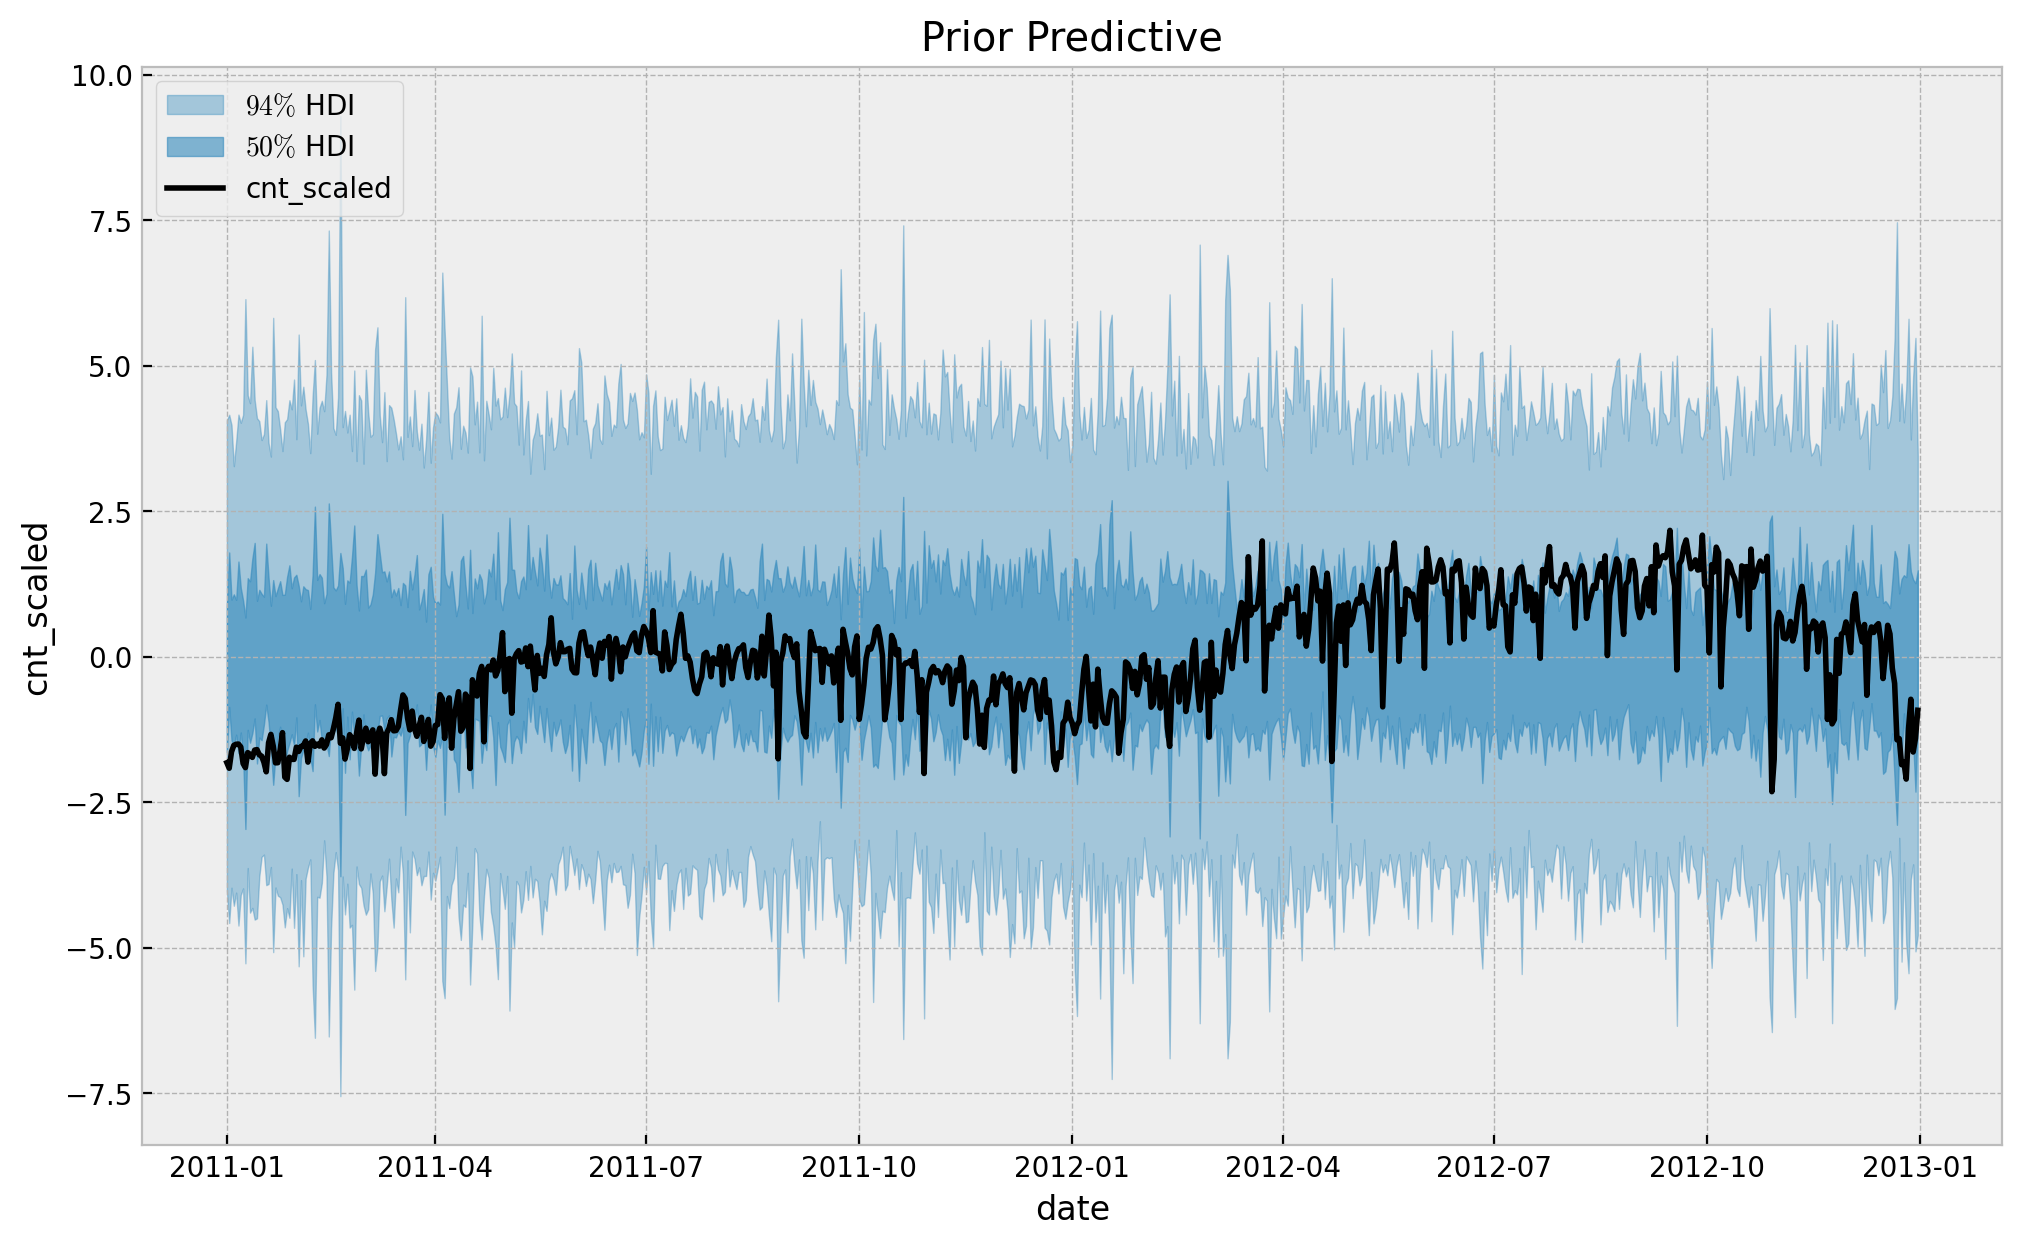

In [9]:
fig, ax = plt.subplots()
az.plot_hdi(
    x=date,
    y=prior_predictive["prior_predictive"]["likelihood"],
    color="C0",
    smooth=False,
    hdi_prob=0.94,
    fill_kwargs={"alpha": 0.4, "label": "$94\%$ HDI"},
    ax=ax,
)
az.plot_hdi(
    x=date,
    y=prior_predictive["prior_predictive"]["likelihood"],
    color="C0",
    smooth=False,
    hdi_prob=0.5,
    fill_kwargs={"alpha": 0.6, "label": "$50\%$ HDI"},
    ax=ax,
)
ax.plot(date, cnt_scaled, color="black", label=target_scaled)
ax.legend(loc="upper left")
ax.set(
    title="Prior Predictive",
    xlabel="date",
    ylabel=target_scaled,
)


In [10]:
with model:
    idata = pm.sample(
        target_accept=0.95,
        draws=2_000,
        chains=5,
        nuts_sampler="numpyro",
        random_seed=rng,
    )
    posterior_predictive = pm.sample_posterior_predictive(trace=idata, random_seed=rng)


/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/pymc/sampling/mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:13.359120
Sampling...


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:01:03.857970
Transforming variables...


Sampling: [likelihood]


Transformation time =  0:00:02.453611


In [11]:
idata["sample_stats"]["diverging"].sum().item()

0

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


Text(0.5, 0.98, 'Time-Varying Coefficient Model - Trace')

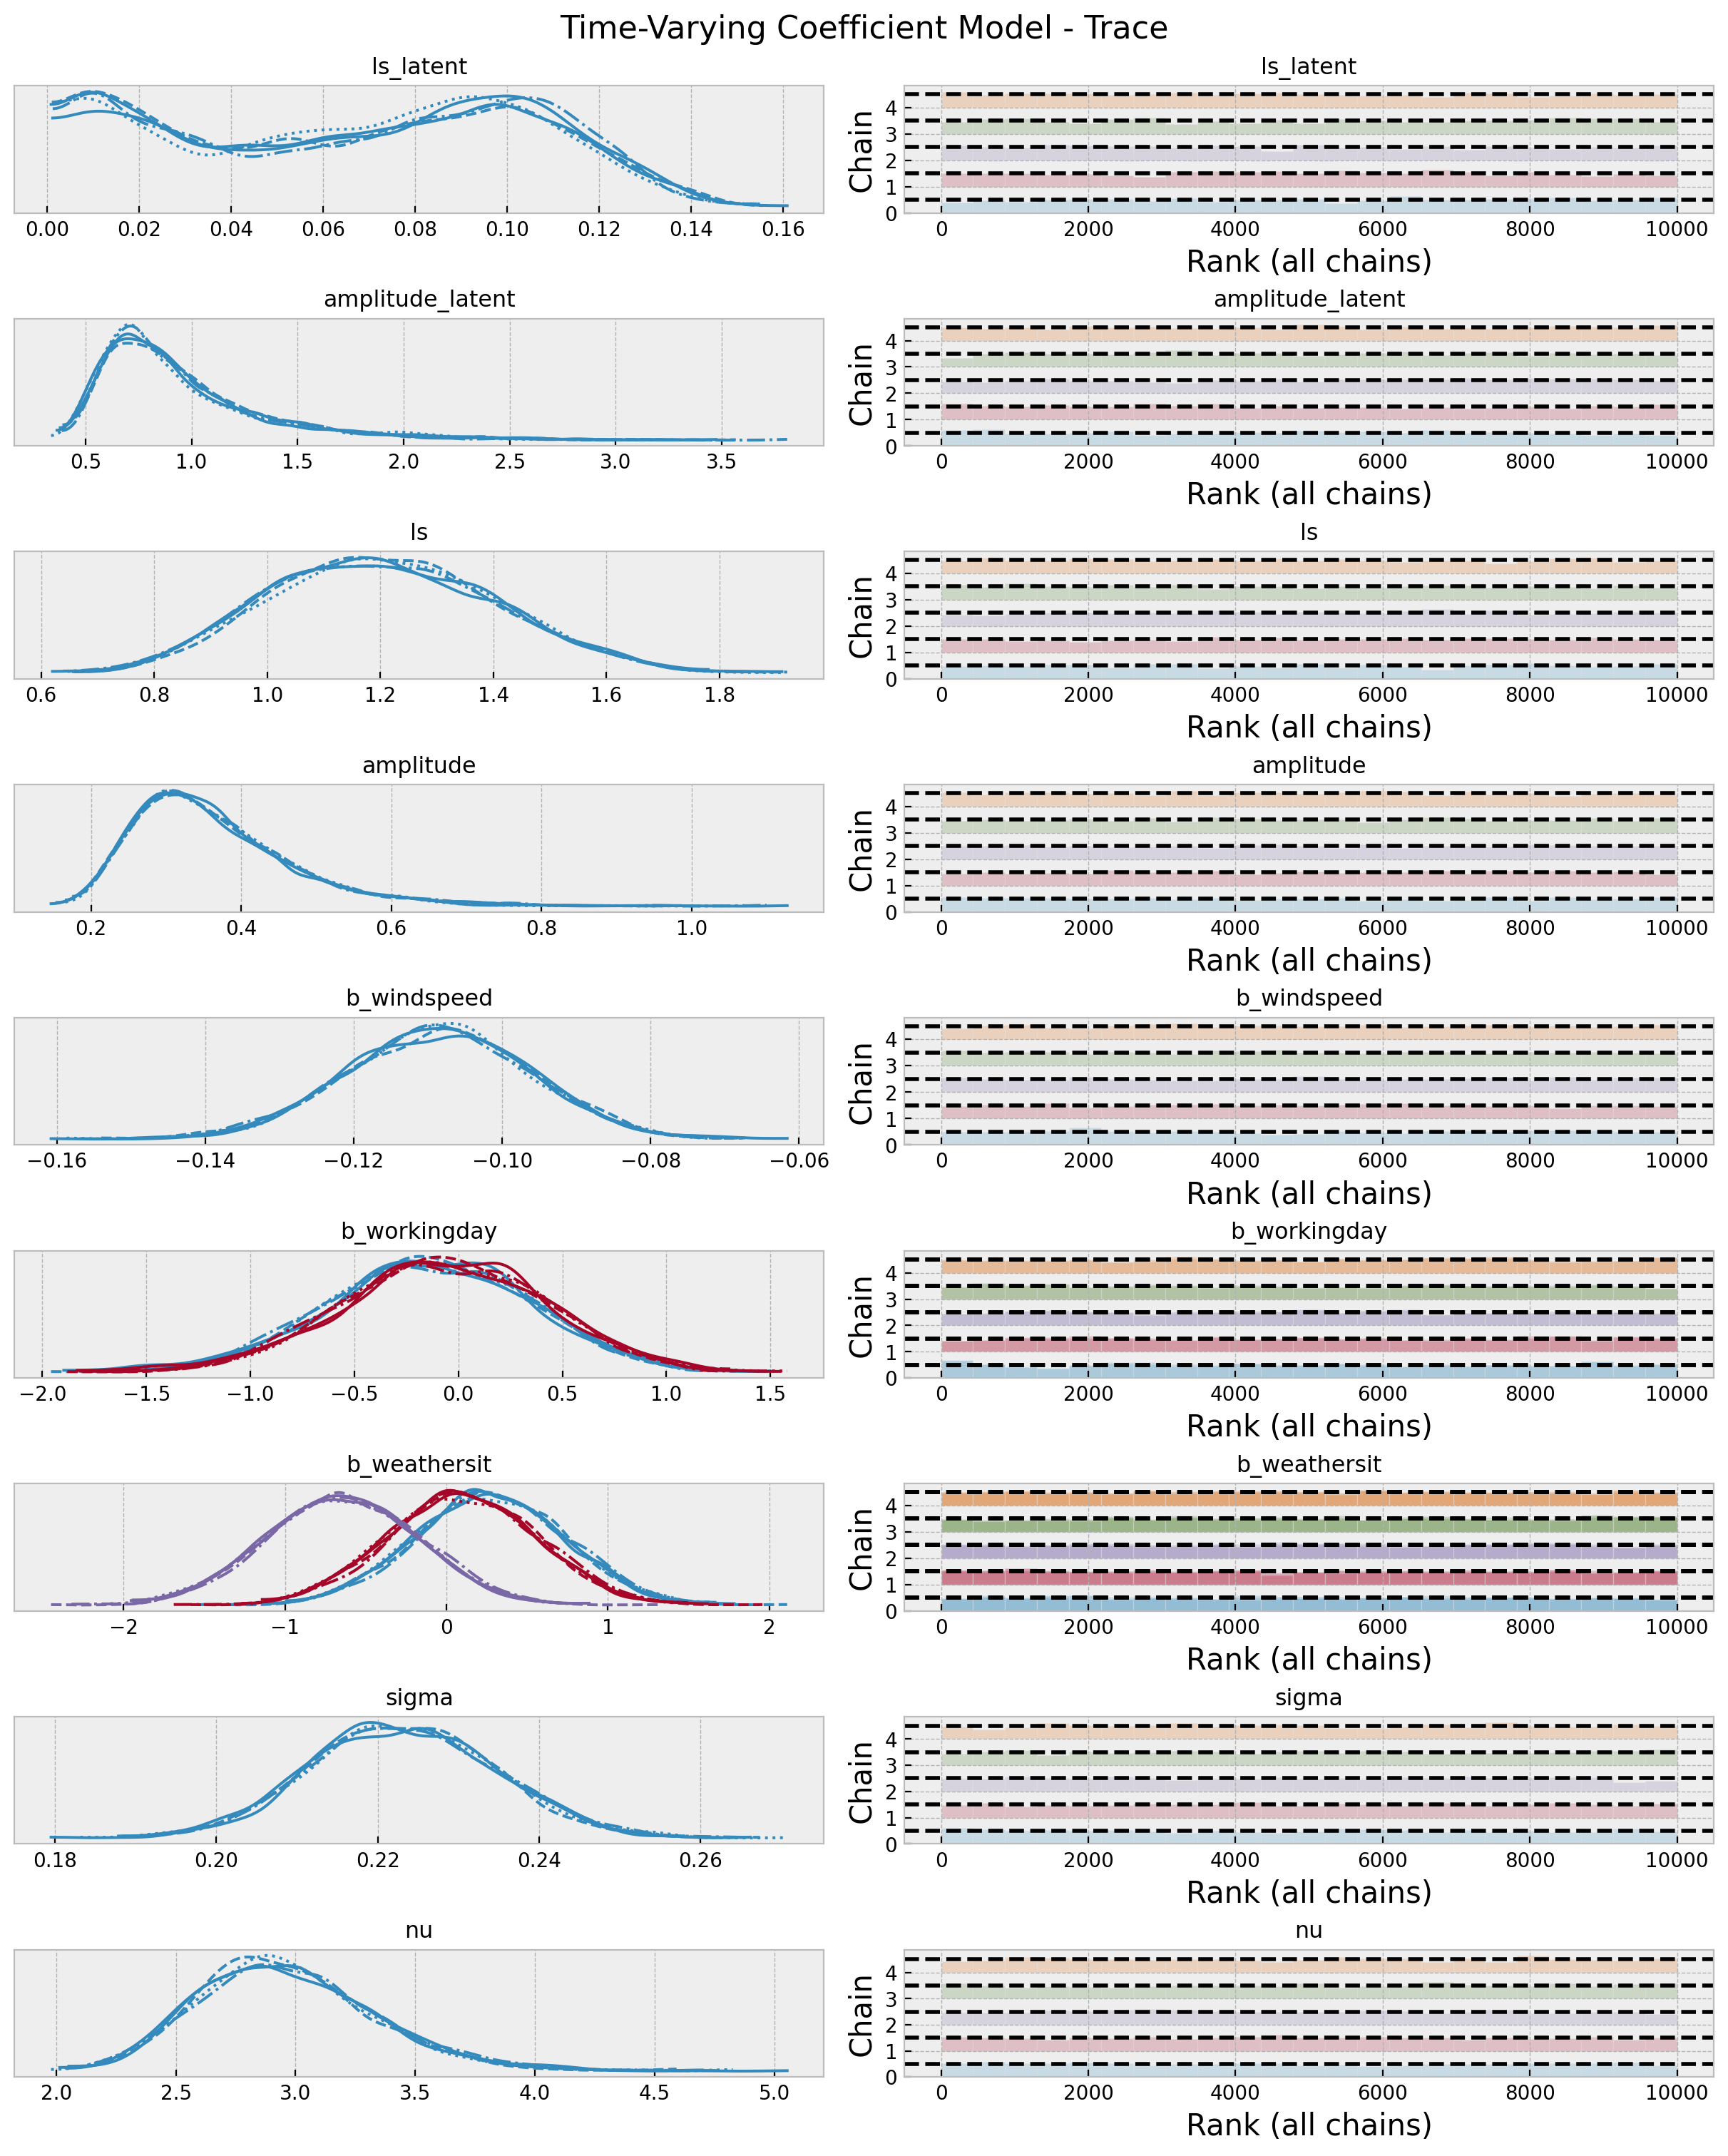

In [12]:
axes = az.plot_trace(
    data=idata,
    var_names=[
        "ls_latent",
        "amplitude_latent",
        "ls",
        "amplitude",
        # "intercept",
        # "b_t",
        "b_windspeed",
        "b_workingday",
        "b_weathersit",
        "sigma",
        "nu",
    ],
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 15), "layout": "constrained"},
)
plt.gcf().suptitle("Time-Varying Coefficient Model - Trace", fontsize=16)


[Text(0.5, 1.0, 'Posterior Predictive'),
 Text(0.5, 0, 'date'),
 Text(0, 0.5, 'cnt_scaled')]

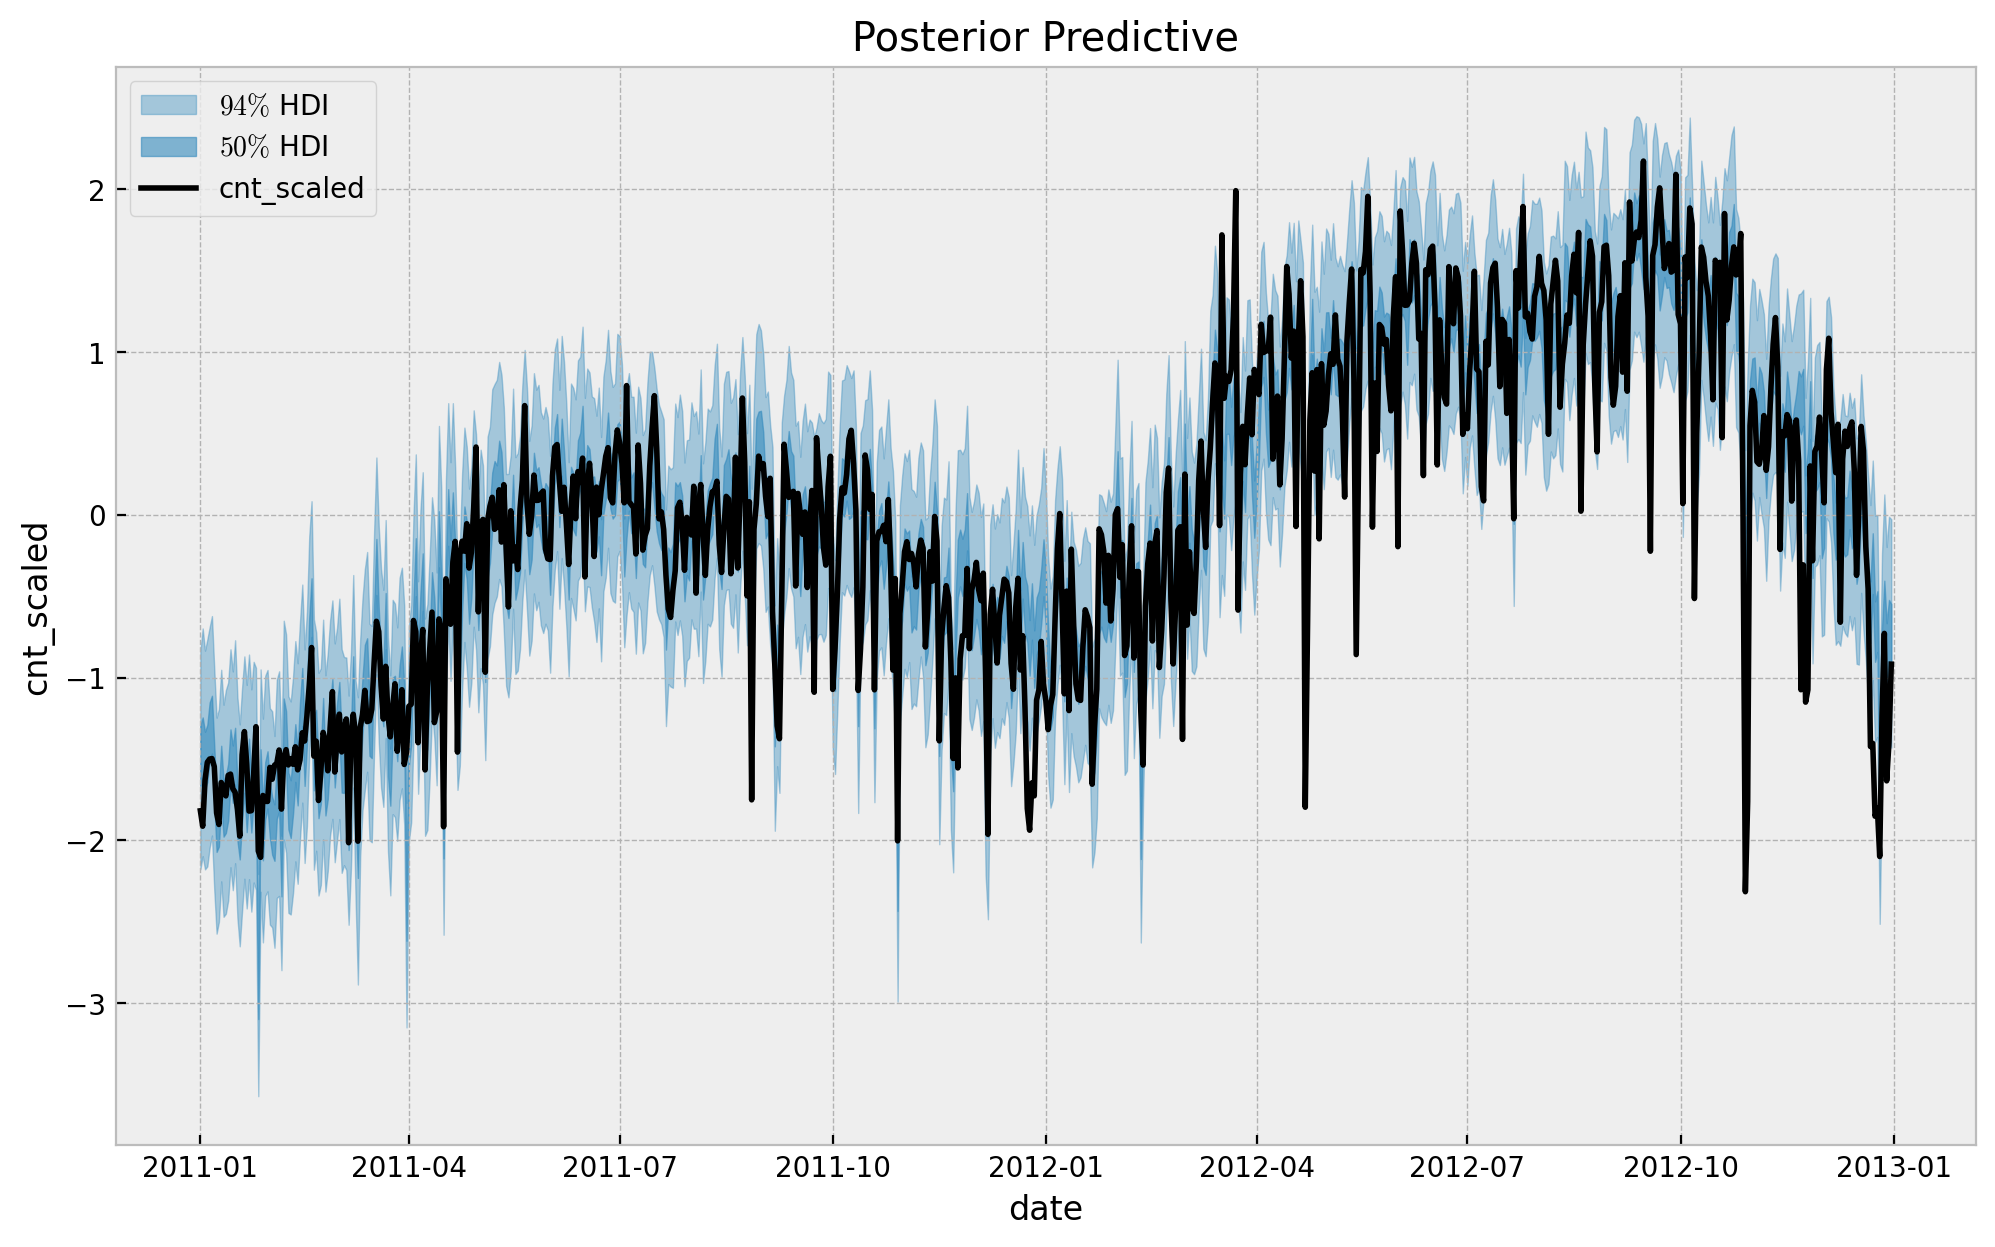

In [18]:
fig, ax = plt.subplots()
az.plot_hdi(
    x=date,
    y=posterior_predictive["posterior_predictive"]["likelihood"],
    color="C0",
    smooth=False,
    hdi_prob=0.94,
    fill_kwargs={"alpha": 0.4, "label": "$94\%$ HDI"},
    ax=ax,
)
az.plot_hdi(
    x=date,
    y=posterior_predictive["posterior_predictive"]["likelihood"],
    color="C0",
    smooth=False,
    hdi_prob=0.5,
    fill_kwargs={"alpha": 0.6, "label": "$50\%$ HDI"},
    ax=ax,
)
ax.plot(date, cnt_scaled, color="black", label=target_scaled)
ax.legend(loc="upper left")
ax.set(
    title="Posterior Predictive",
    xlabel="date",
    ylabel=target_scaled,
)

<AxesSubplot:>

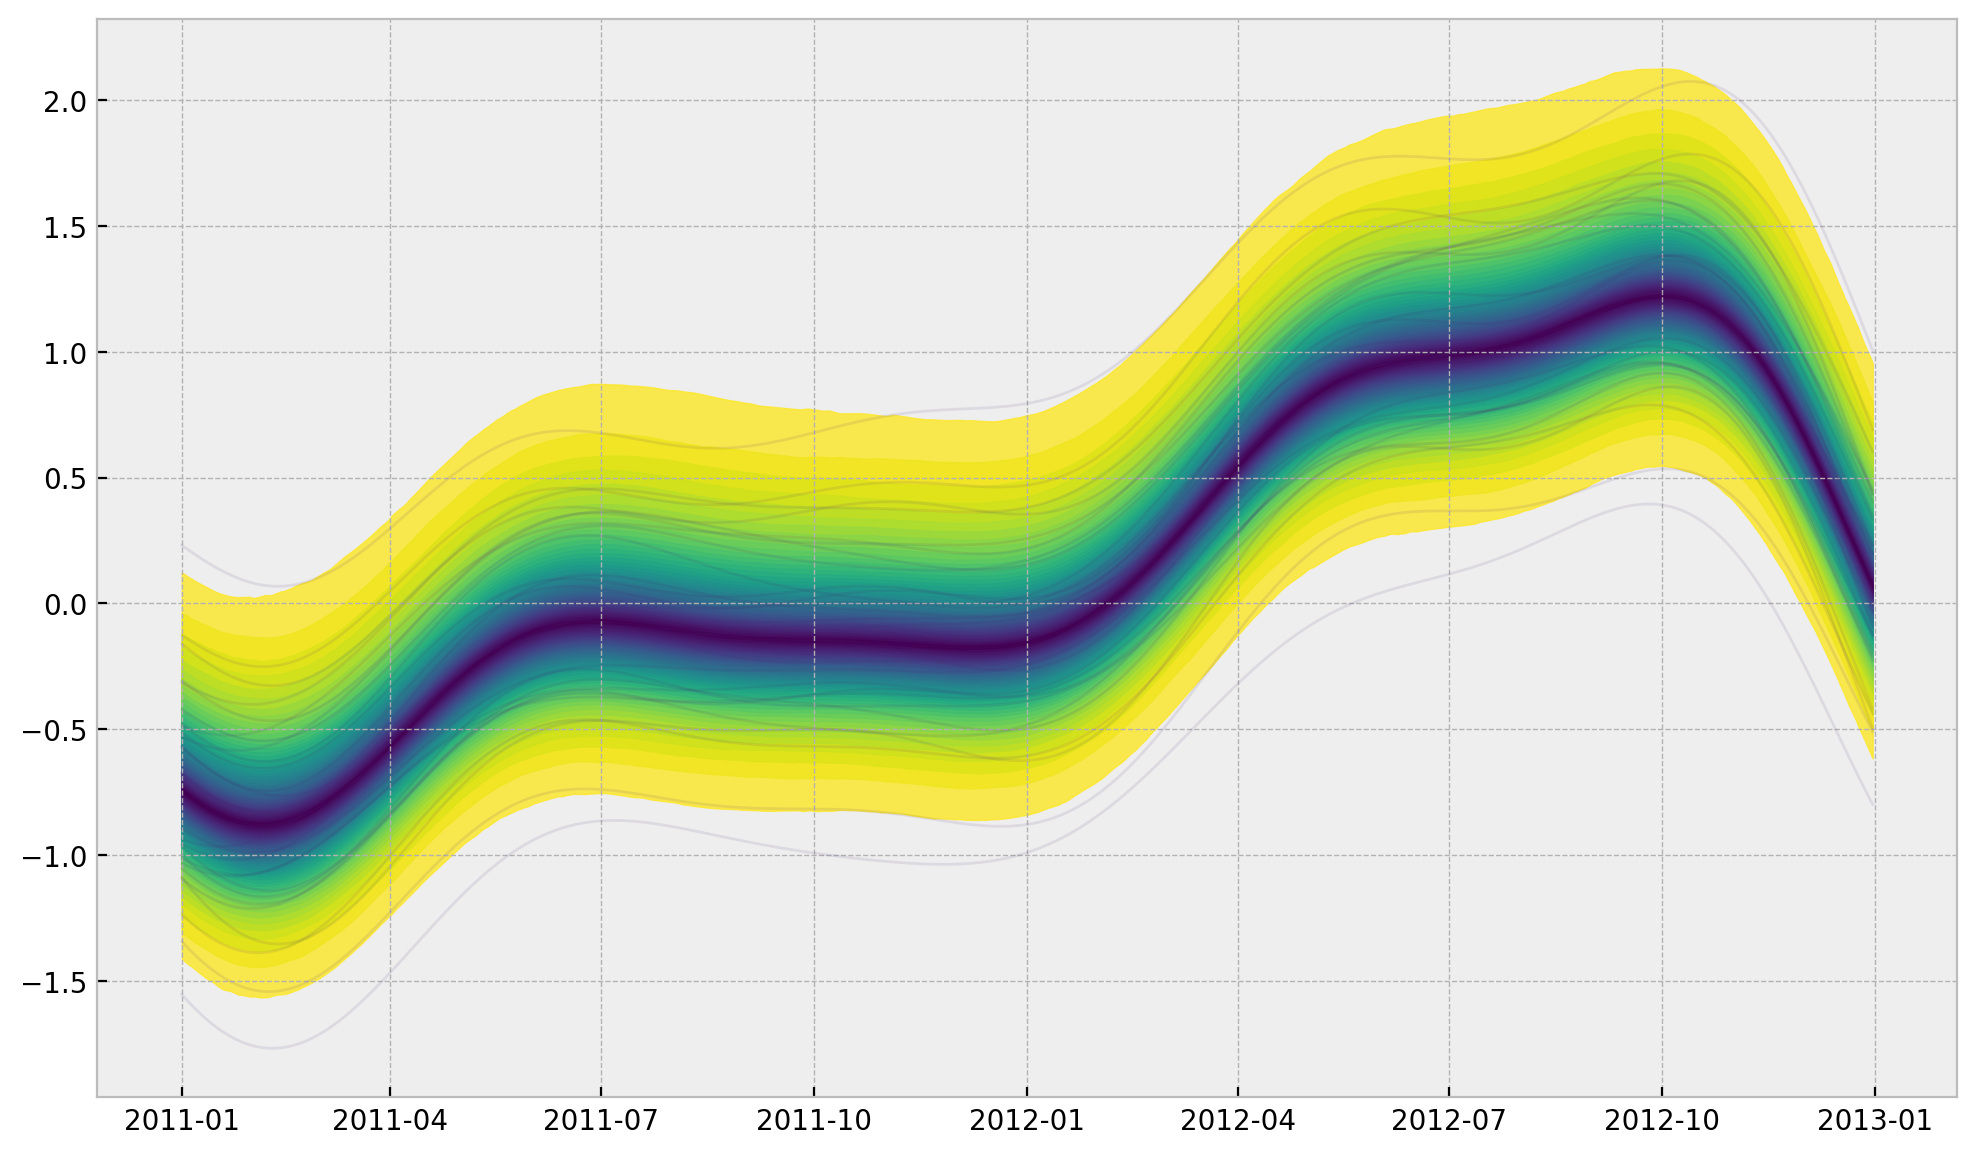

In [13]:
f_latent_samples = az.extract(data=idata, var_names=["f_latent"]).transpose(
    "sample", ...
)

fig, ax = plt.subplots()
plot_gp_dist(
    ax=ax,
    samples=f_latent_samples,
    x=date,
    palette="viridis_r",
)

<AxesSubplot:>

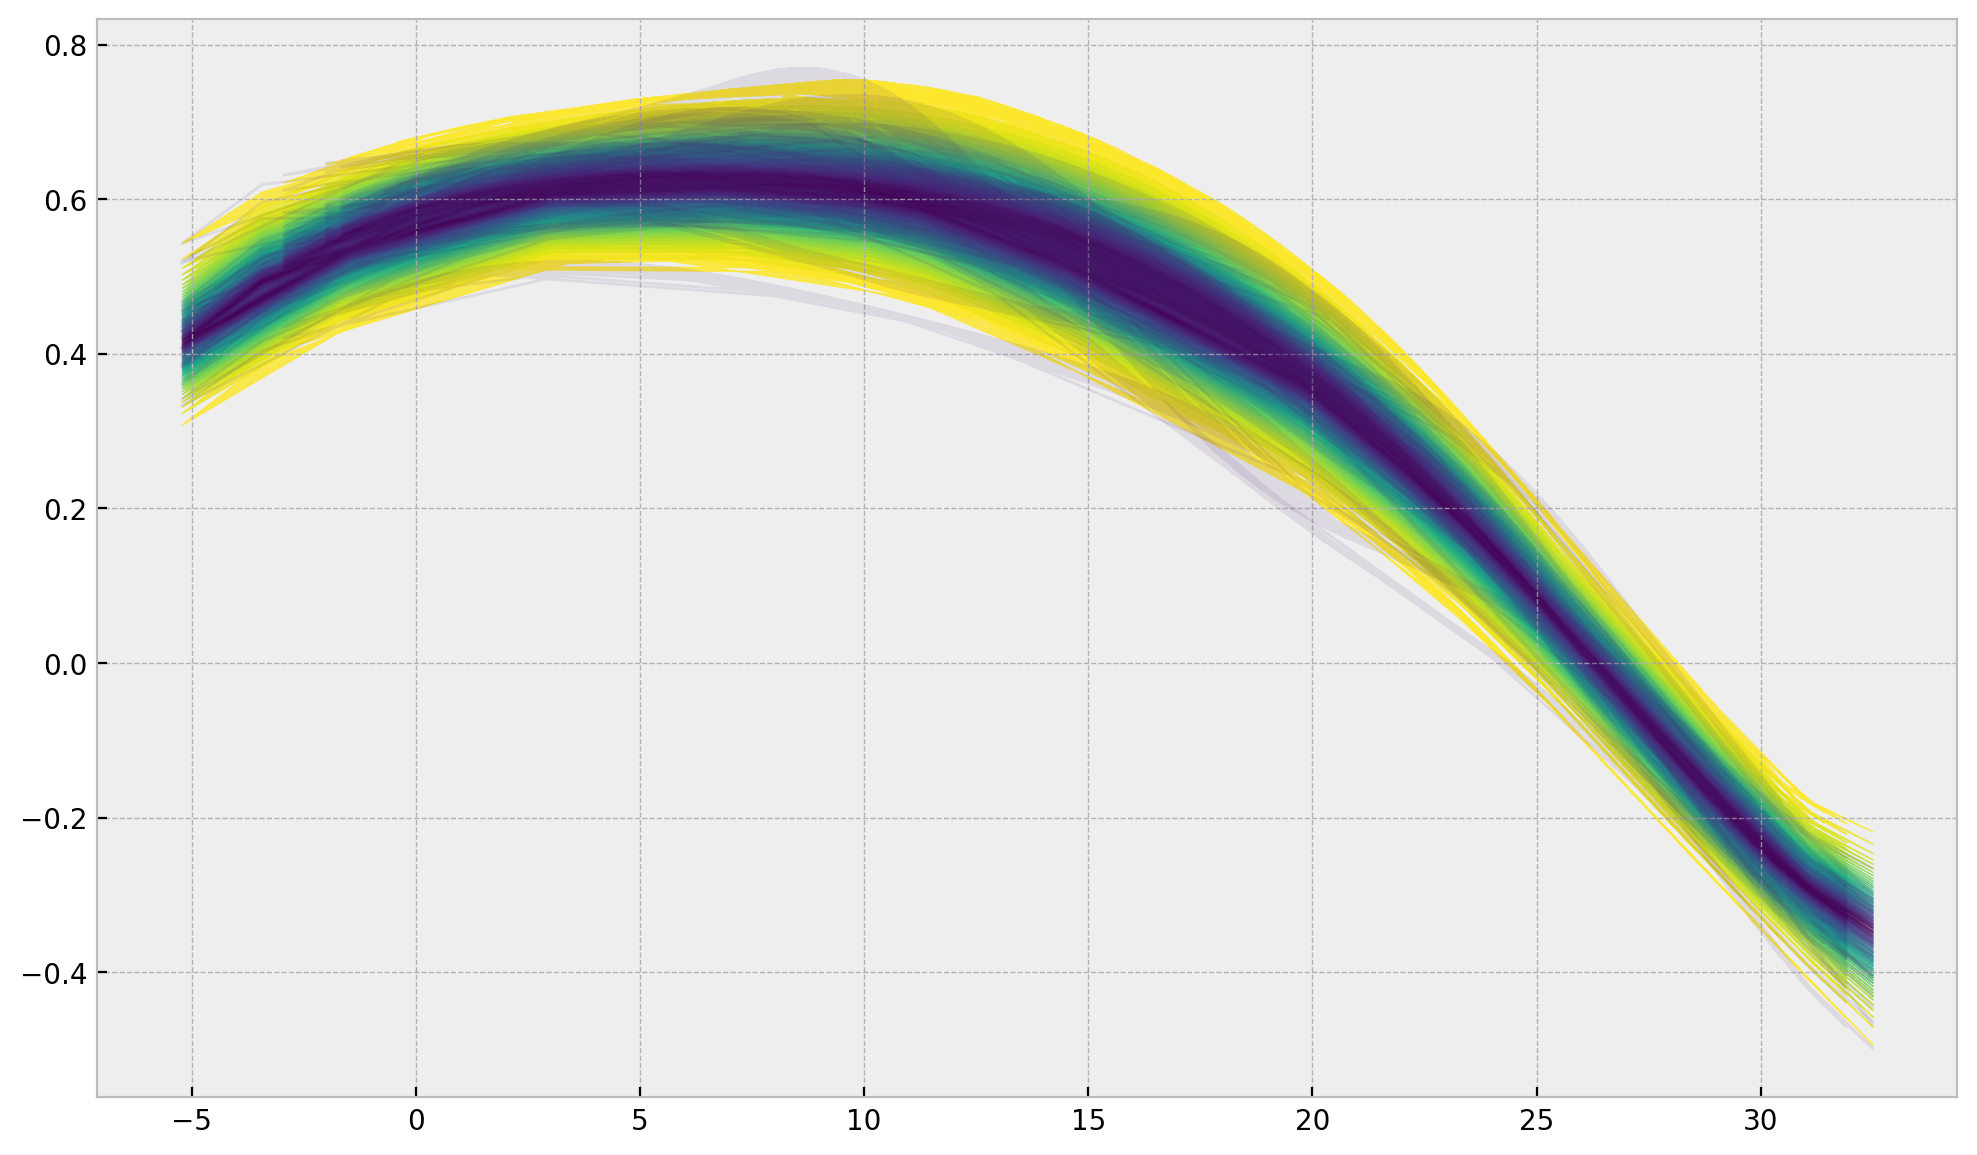

In [14]:
b_temp_samples = az.extract(data=idata, var_names=["b_temp"]).transpose("sample", ...)

fig, ax = plt.subplots()
plot_gp_dist(
    ax=ax,
    samples=b_temp_samples,
    x=data_df["temp"].to_numpy(),
    palette="viridis_r",
)


<AxesSubplot:>

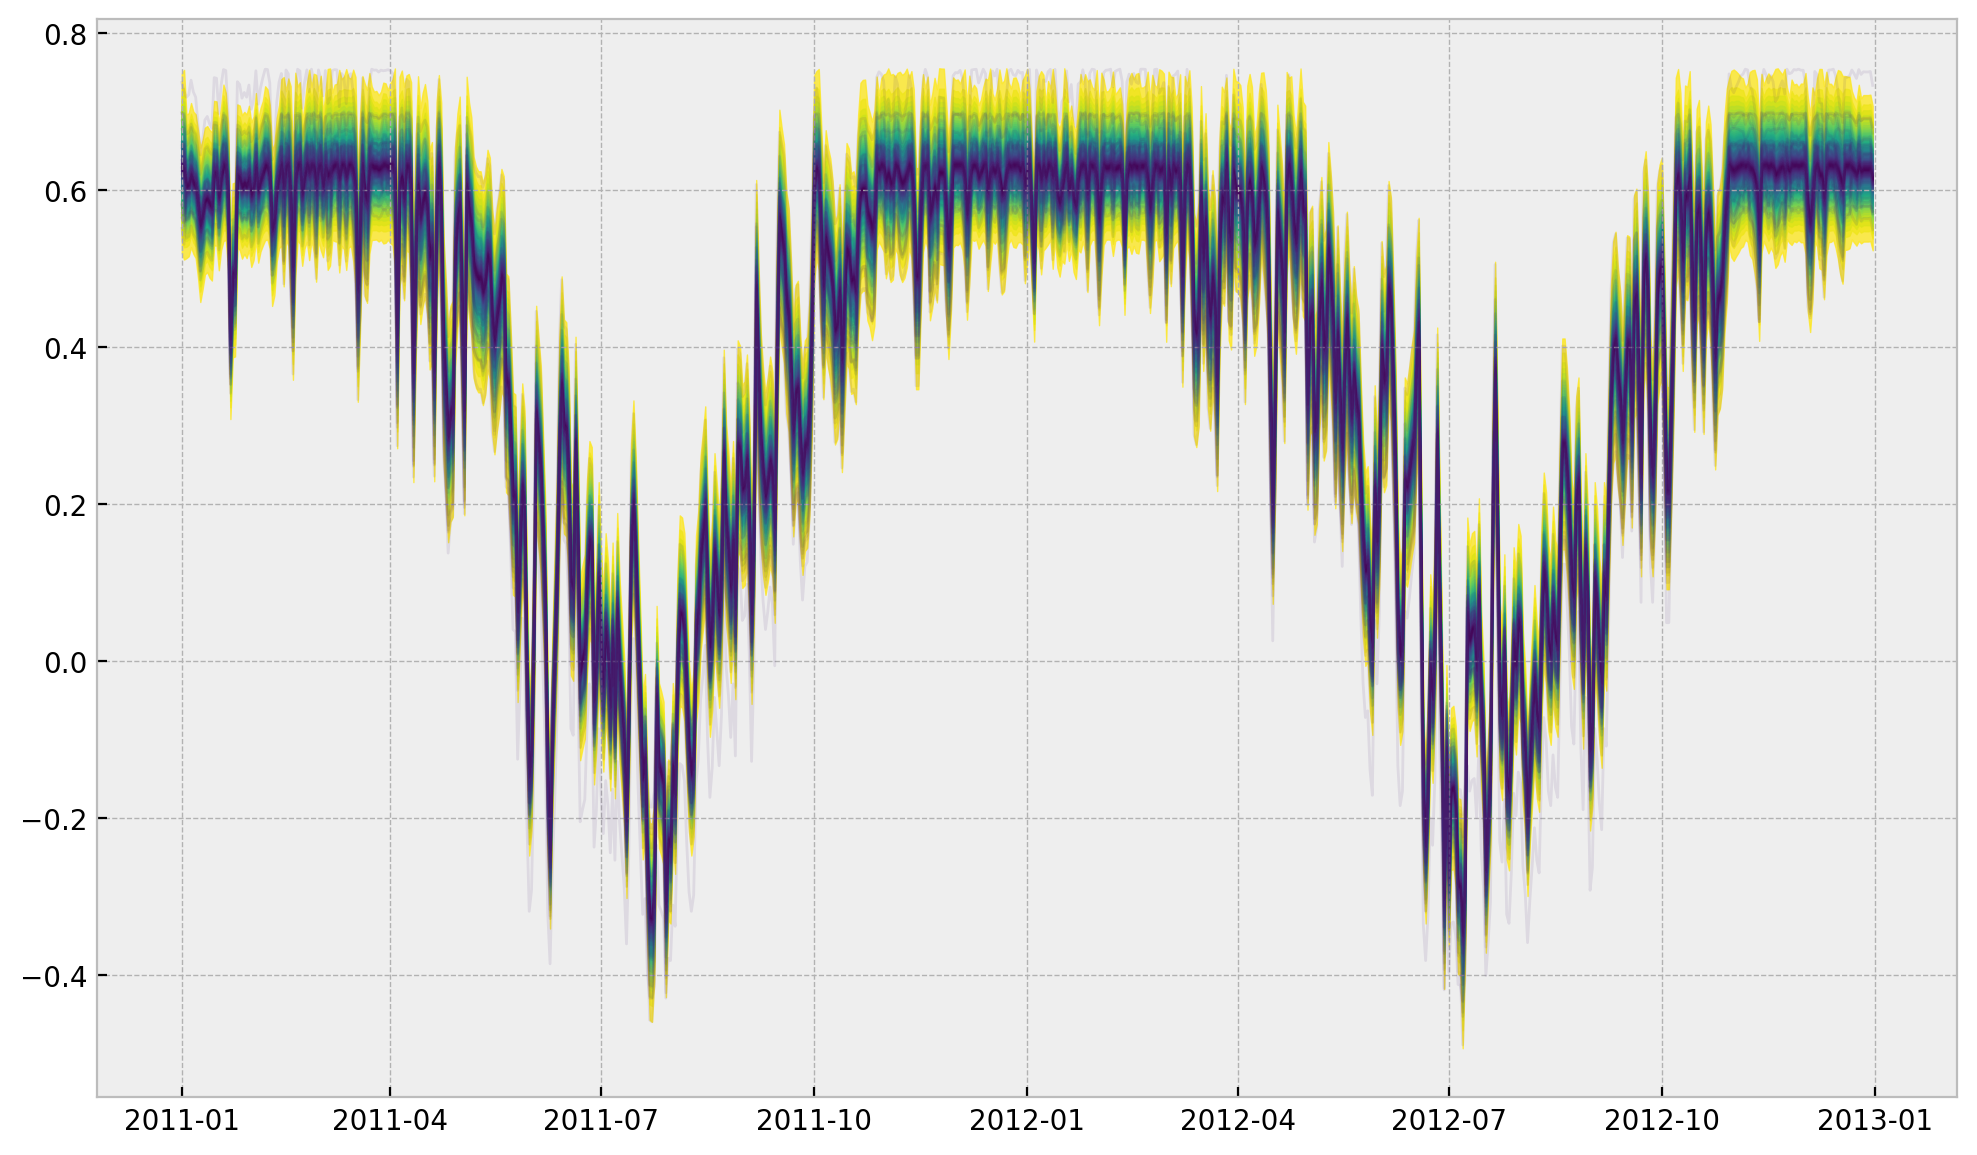

In [15]:
fig, ax = plt.subplots()
plot_gp_dist(
    ax=ax,
    samples=b_temp_samples,
    x=date,
    palette="viridis_r",
)


<AxesSubplot:>

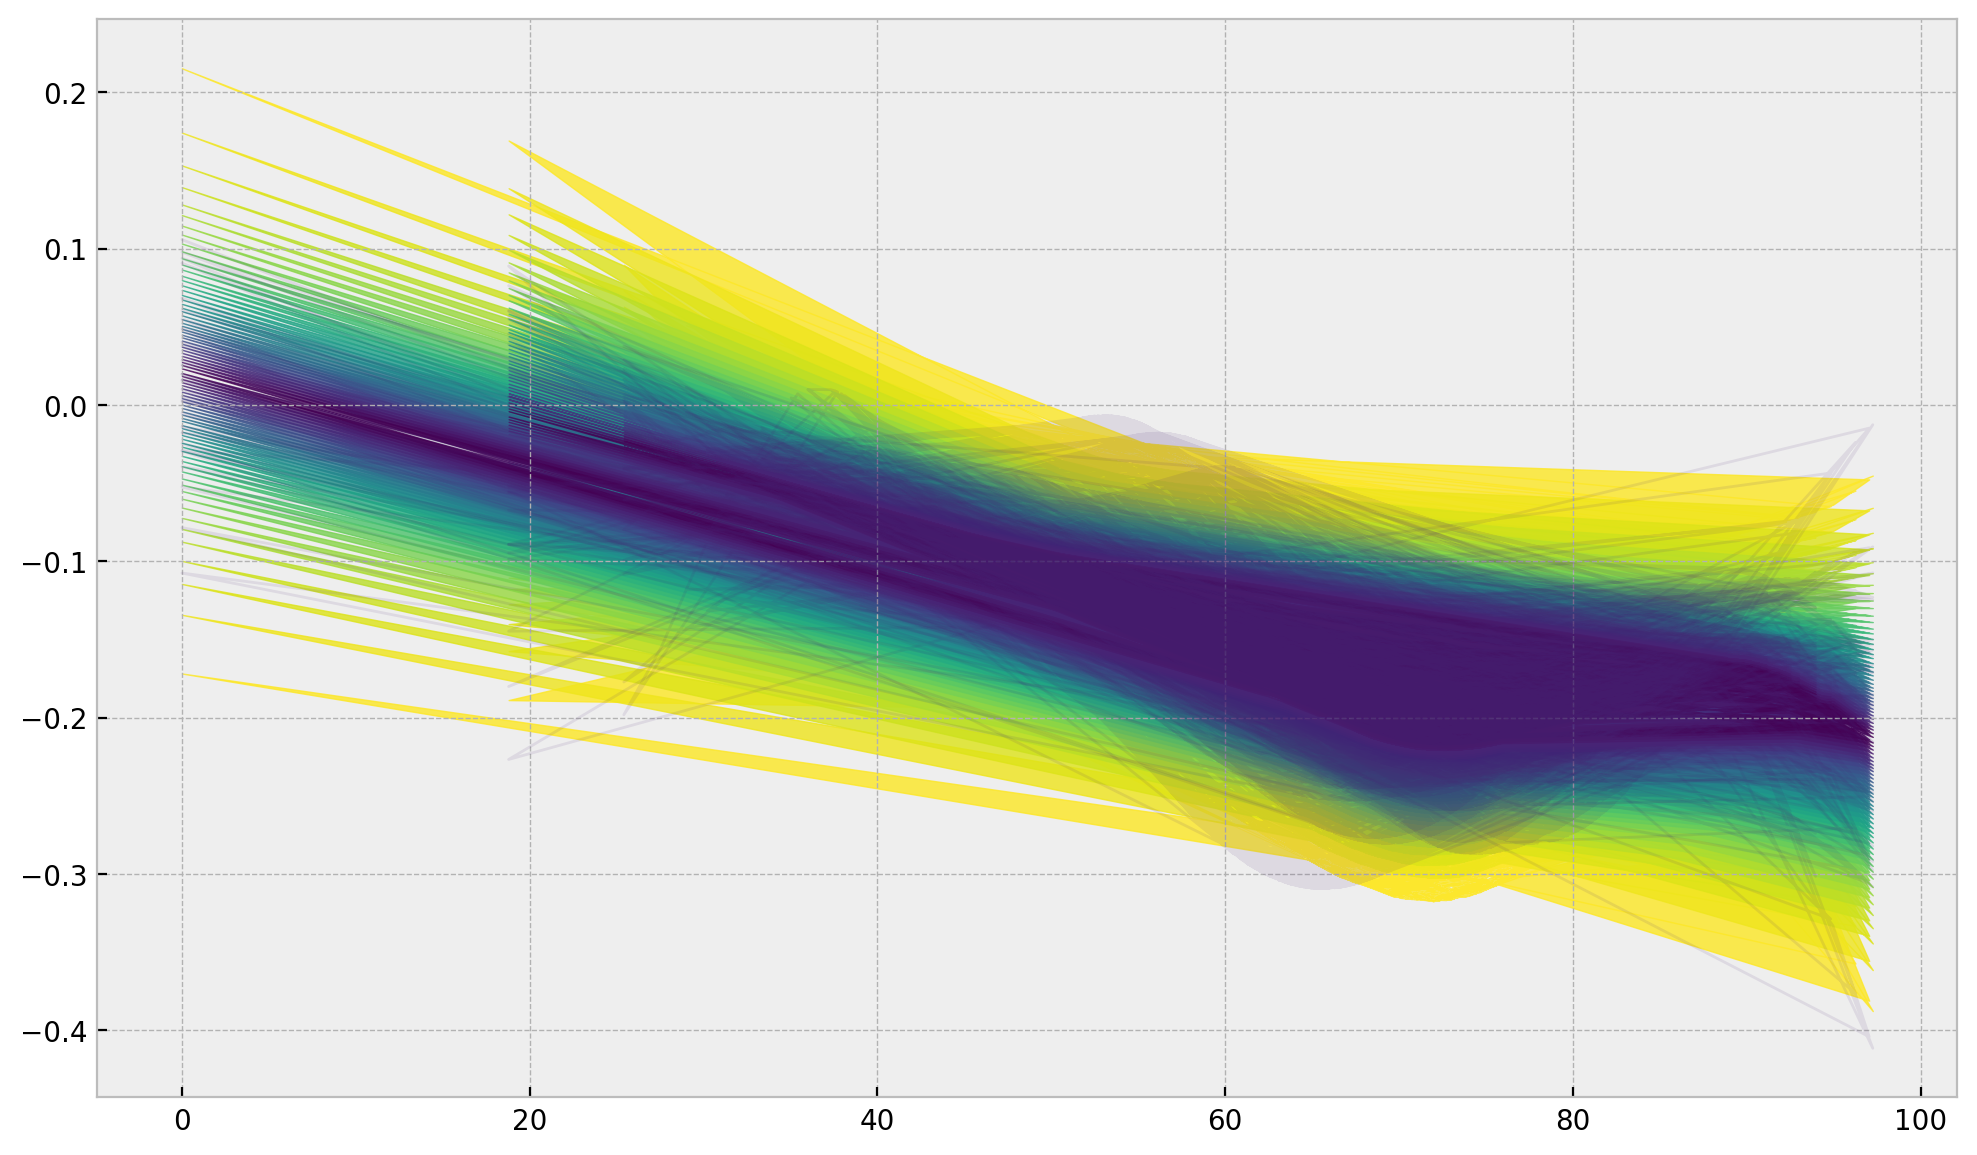

In [16]:
b_hum_samples = az.extract(data=idata, var_names=["b_hum"]).transpose("sample", ...)

fig, ax = plt.subplots()
plot_gp_dist(
    ax=ax,
    samples=b_hum_samples,
    x=data_df["hum"].to_numpy(),
    palette="viridis_r",
)


<AxesSubplot:>

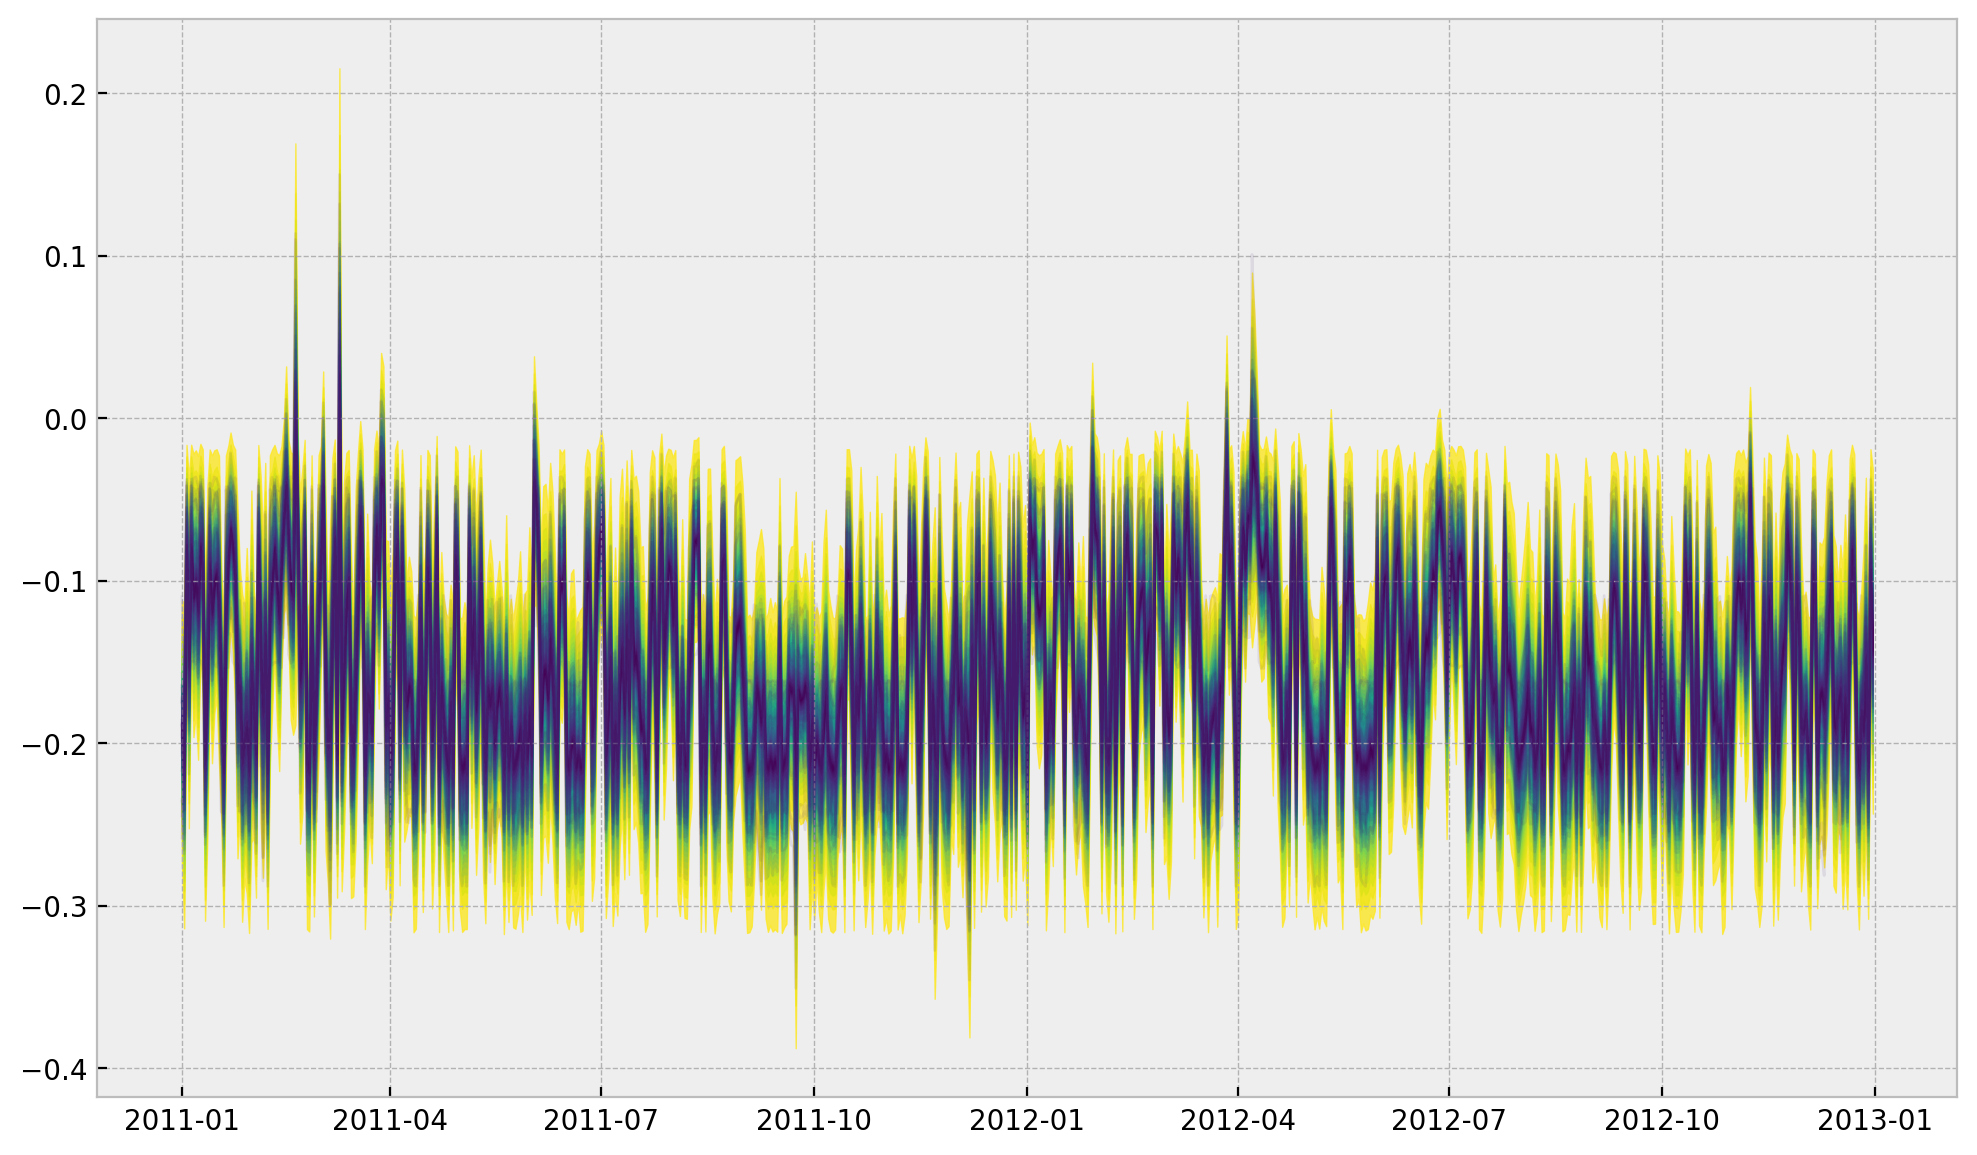

In [17]:
fig, ax = plt.subplots()
plot_gp_dist(
    ax=ax,
    samples=b_hum_samples,
    x=date,
    palette="viridis_r",
)